### Define utils

In [1]:
import numpy as np
import netCDF4 as nc
import glob, os
import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}
mpl.rc('font', **font)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import pandas as pd
from cmcrameri import cm
import matplotlib.transforms as transforms
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [2]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands

from utils import ppr as ppr
from utils import load_grid as lg

In [3]:
def planck_spec(x, tmp):
    # x:   wavelengths in [nm]
    # tmp: temperature in [K]
    y = np.zeros(len(x))
    for j in range(len(x)):
        y[j] = ppr.planck(x[j]*1e3, tmp)
    return y

In [4]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [5]:
# pltname = "output/agni_v_janus/hd63433d"
# outname = "article_data/mnras_proteus_agni/hd63433d_oxfu/"
# title = "HD 63433 d"

# pltname = "output/agni_v_janus/trappist1c"
# outname = "article_data/mnras_proteus_agni/trappist1c_oxfu/"
# title = "TRAPPIST-1 c"

pltname = "output"
outname = "output/_l9859/l9859d_grid5/"
title = "L 98-59 d"

In [6]:
folder = os.path.join(os.environ.get("HOME"),"analysis/data/", outname) + "/"

In [7]:
globber = folder + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
for f in cases:
    conf.append( read_config(f+"init_coupler.toml") )
    post.append( ppr.read_postproc(f) )

cases = lg.get_cases(folder)
helps, hvars = lg.load_helpfiles(cases)
print("Done")

/home/n/nichollsh/analysis/data/output/_l9859/l9859d_grid5///case_*/
npoints = 192


Helpfiles: 100%|██████████| 192/192 [00:02<00:00, 65.60it/s]


Done


In [8]:
plt.close("all")

In [9]:
indep_var = "outgas.fO2_shift_IW"
indep_lbl = r"log$_{10}$ (fO$_{2}$ / IW)"
cbar_sym = True
cbar_scl = "linear"

# indep_var = "orbit.dummy.H_tide"
# indep_lbl = r"$H_{\text{tide}}$ [W kg$^{-1}$]"
# cbar_sym = False
# cbar_scl = "Linear"

# indep_var = "delivery.elements.H_ppmw"
# indep_lbl = "Hydrogen content [ppmw]"
# cbar_sym = False
# cbar_scl = "linear"

In [10]:
indep_vals = set()
for i in range(npoints):
    indep_vals.add(lg.descend_get(conf[i],indep_var))

indep_unique = np.unique(list(indep_vals))
print(indep_unique)

indep_max = np.amax(list(indep_unique))
indep_min = np.amin(list(indep_unique))

if cbar_sym:
    indep_max = max(indep_max, abs(indep_min))
    indep_min = -1.0 * indep_max

[-6. -3.  3.  6.]


In [11]:
cmap = cm.batlow_r
if cbar_scl == "symlog":
    linthresh = indep_min / 1e1
    if linthresh == 0:
        linthresh = indep_max / 1e6
    norm = mpl.colors.SymLogNorm(vmin=0, vmax=indep_max, linthresh=linthresh)

elif cbar_scl == "log":
    norm = mpl.colors.LogNorm(vmin=indep_min, vmax=indep_max)

else:
    norm = mpl.colors.Normalize(vmin=indep_min, vmax=indep_max)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

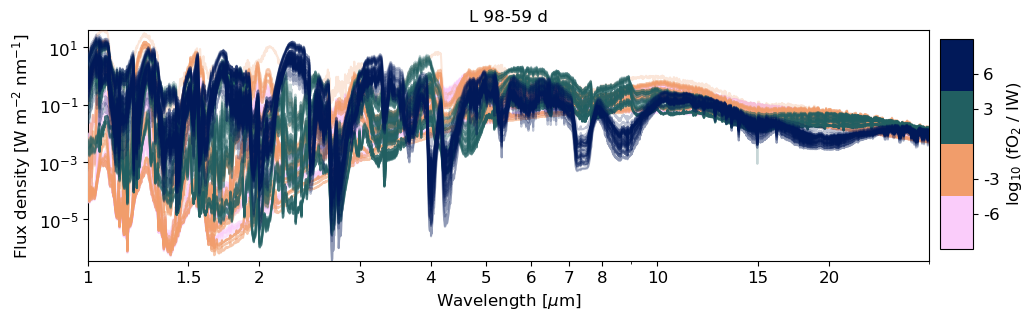

output/_l9859/l9859d_grid5/


In [12]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(11,3))

plot_type = "emission"
planck_tmps = []# [250, 300, 350, 400, 450, 700]
time_idx = -1
al = 0.25
show_inst = False
show_xlbl = True

if plot_type == "emission":
    ylim = [1e2, 1e-5]
    xlim   = [1, 30.0]
    xticks = [1,1.5,2,3,4,5,6,7,8,  10,15,20]
    logy = True
    logx = True
    instruments = [
        "ELT.HARMONI", "NIRSpec.F290LP",
        "NIRISS.SOSS",
        "IR.J","IR.H","IR.K","IR.L","IR.M",
        "MIRI",
        ]

elif plot_type == "albedo":
    ylim = [0, 100]
    xlim = [0.3, 1.0]
    xticks = np.arange(xlim[0], xlim[1], 0.05)
    logy = False
    logx = False
    instruments = ["VLT", "CARMENES", "GEMINI-N", "NIRISS"]

# plot emission spectra
for i in range(npoints):
    if lg.descend_get(conf[i],"atmos_clim.module") == 'janus':
        continue

    dat = post[i]
    lbl = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(float(lbl))
    ls = 'solid'

    x = np.abs(dat["bandmax"] + dat["bandmin"]) * 0.5 * 1e6
    w = np.abs(dat["bandmax"] - dat["bandmin"]) * 1e9

    if plot_type == "emission":
        y = np.abs(dat["ba_U_SW"][time_idx] + dat["ba_U_LW"][time_idx]) / w
    elif plot_type == "albedo":
        y = 100* np.abs(dat["ba_U_SW"][time_idx] / dat["ba_D_SW"][time_idx])

    # crop to observed region
    mask = np.argwhere( (x >= xlim[0]) & (x <= xlim[1]))
    x = x[mask]
    y = y[mask]
    w = w[mask]

    ylim[1] = max(ylim[1], np.amax(y[2:]))
    ylim[0] = min(ylim[0], np.amin(y[2:]))
    ax.plot(x,y, linestyle=ls, c=col, zorder=i*2, alpha=al, label=lbl)

if len(planck_tmps) > 0:
    x_pl = np.logspace(np.log10(xlim[0]-0.5),np.log10(xlim[1]+0.5),150)
    for tmp in planck_tmps:
        col = None
        if tmp == 450:
            col = 'k'
        y_pl = planck_spec(x_pl,tmp)
        ax.plot(x_pl,y_pl, zorder=0, label="%d K"%tmp, color=col)

    ax.legend(ncols=2, title="Blackbody emission")

# plot instrument bandpasses
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
top  = True  # show at top?
h    = 0.04  # height of annotations
s    = 0.05 # spacing between annotations
yt   = 0.97  # axis y-pos of topmost annotation
xeps = 1.2   # delta x between annotations

if show_inst:
    ylim[1] = ylim[1] * 6

    if not top:
        yt = 1-yt
        s  = -s

    prev_bands = []
    i = -1
    for ins in instruments:
        if "." in ins:
            ins = ins.split(".")
            bands = {ins[1]:observer_bands[ins[0]][ins[1]]}
        else:
            bands = observer_bands[ins]

        print(bands)

        # for each band associated with this instrument
        for b in bands:
            v = bands[b]
            if v[0] > xlim[1]:
                continue

            i += 1

            # work out where to position this band on the plot
            if i == 0:
                y0 = yt
            else:
                for j in range(30):
                    # try this y-location
                    ok = True
                    y0 = yt - j * s

                    # check there's no overlap with other bands
                    for p in prev_bands:
                        if np.isclose(p[2],y0):
                            if (p[0]< v[1] < p[1]) or (p[0] < v[0] < p[1]):
                                ok = False
                                break
                    if ok:
                        break
            prev_bands.append([v[0]/xeps,v[1]*xeps,y0])
            prev_bands.append([v[0],v[1],y0])

            # band rectangle
            ax.add_patch(mpatches.Rectangle( (v[0], y0-h/2), width=v[1]-v[0], height=h,
                                            transform=trans,
                                            alpha=0.7, zorder=98, color='dodgerblue'))

            # band label
            x0 = np.sqrt(v[0]*v[1])
            if x0>xlim[1]:
                x0 = np.sqrt(v[0]*xlim[1])
            if v[0]<xlim[0]:
                x0 = np.sqrt(v[1]*xlim[0])
            ax.text(x0, y0 , b, fontsize=7, color='k', weight='bold',
                    clip_on=True, zorder=99, transform=trans,
                    rotation=-0, horizontalalignment='center', verticalalignment='center')

# decorate plot
if len(indep_unique) > 3:
    lg.add_cbar(fig, sm, ticks=indep_unique, label=indep_lbl, width=0.03, squeeze=0.90, tick_format="%g")
else:
    lg.make_legend(ax, set_color=None, title=indep_lbl)
ax.set_ylim(bottom=ylim[0], top=ylim[1])
ax.set_title(title, fontsize=12)
ax.set_xlim(xlim)
if logx:
    ax.set_xscale("log")
if logy:
    ax.set_yscale("log")
ax.xaxis.set_major_formatter(FormatStrFormatter("%g"))

ax.set_xticks(xticks)
if show_xlbl:
    ax.set_xlabel(r"Wavelength [$\mu$m]")

ylabel = "_default"
if plot_type == "emission":
    ylabel = r"Flux density [W m$^{-2}$ nm$^{-1}$]"
elif plot_type == "albedo":
    ylabel = r"Spectral albedo [%]"
ax.set_ylabel(ylabel)

# plot and save

plt.show()
print(outname)

In [13]:
for fmt in ["png","pdf"]:
    fig.savefig("%s/%s_ppr.%s"%(pltname,plot_type,fmt),bbox_inches='tight', dpi=300)

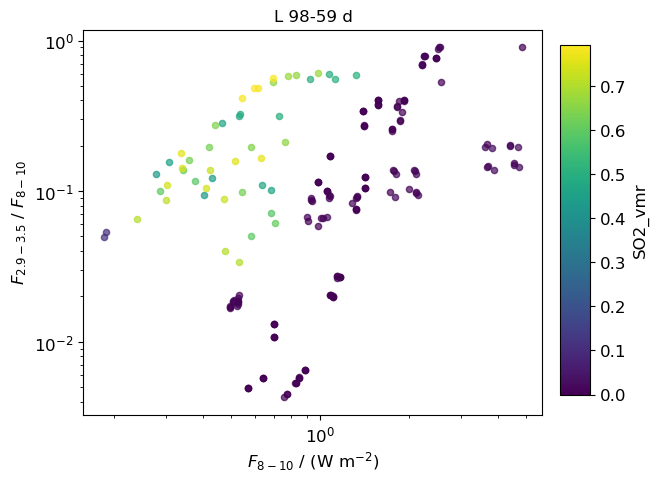

output/_l9859/l9859d_grid5/


In [53]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(6,5))

x_band = [8, 10]
y_band = [2.9, 3.5]
z_var  = "SO2_vmr"
z_scl  = "linear"

z_vals = lg.access_hvars(hvars, z_var, -1)
z_min, z_max = np.amin(z_vals), np.amax(z_vals)
cmap = "viridis"
if z_scl == "symlog":
    norm = mpl.colors.SymLogNorm(vmin=z_min, vmax=z_max, linthresh=0.1)
else:
    norm = mpl.colors.Normalize(vmin=z_min, vmax=z_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

ms = 20
al = 0.7

# plot emission spectra
for i in range(npoints):
    if lg.descend_get(conf[i],"atmos_clim.module") == 'janus':
        continue

    dat = post[i]
    lbl = z_vals[i]
    col = sm.to_rgba(float(lbl))

    x = np.abs(dat["bandmax"] + dat["bandmin"]) * 0.5 * 1e6
    w = np.abs(dat["bandmax"] - dat["bandmin"]) * 1e9
    y = np.abs(dat["ba_U_SW"][time_idx] + dat["ba_U_LW"][time_idx]) / w

    # x_band
    mask = np.argwhere( (x >= x_band[0]) & (x <= x_band[1]))
    x_x = x[mask][0]
    x_y = y[mask][0]
    x_w = w[mask][0]
    x_f = np.dot(x_y,x_w) # integrated flux W/m^2

    # y_band
    mask = np.argwhere( (x >= y_band[0]) & (x <= y_band[1]))
    y_x = x[mask][0]
    y_y = y[mask][0]
    y_w = w[mask][0]
    y_f = np.dot(y_y,y_w) # integrated flux W/m^2
    y_f /= x_f

    ax.scatter(x_f,y_f, color=col, zorder=i*2, alpha=al, label=lbl, s=ms)

# decorate plot
lg.add_cbar(fig, sm, label=z_var, width=0.05, squeeze=0.92)

ax.set_title(title, fontsize=12)
x_lbl = r"$F_{%g-%g}$"%(x_band[0],x_band[1])
ax.set_xlabel(x_lbl + r" / (W m$^{-2}$)")
ax.set_ylabel(r"$F_{%g-%g}$ / "%(y_band[0],y_band[1])+x_lbl)

ax.set_xscale("log")
ax.set_yscale("log")

# plot and save
plt.show()
print(outname)